
# Basic Tutorial

In this tutorial you will learn the basics of `aiida-phonopy`.
At the core of the package are the data types wrapping the Phonopy classes to generate structures in AiiDA, connecting them in the graph.

We can divide the main workflow of Phonopy in two phases:

* __Pre-processing__: generate the (supercell) structures with displacements on top of which to compute the forces (for frozen phonons).
* __Post-process__: collect the data, ideally in a compact way, and use it for extracting phonon-related properties.

In this tutorial we will make use of the silicon structure to give you an overall understanding of the usage of the package.
If you are interested in more advanced features, please have a look at the [next tutorial](./intermidiate.ipynb) or to the [how tos](../howto/index.rst).

Let's get started!

## Generating supercell structures

In a frozen phonon calculation, you need to first define the structures with displacements on top of which computing the forces.
Here, you will learn how to do so in AiiDA, and how to obtain the displaced structures
as {py:class}`~aiida.orm.StructureData` instances with full provenance.

```{admonition} Exercise
We will use the silicon structure throughout the tutorials, but this can be easily
substituted with any structure of your interest.
```

First, import the required classes and functions:

In [1]:

from local_module import load_temp_profile
from aiida.plugins import DataFactory

# If you download this file, you can run it with your own profile.
# Put these lines instead:
# from aiida import load_profile
# load_profile()
load_temp_profile(
    name="basic-tutorial",
    add_computer=True,
    add_phonopy_code=True,
)


StructureData = DataFactory("core.structure")

Let's define the silicon structure using the ASE module:

In [2]:
# Create a silicon cubic crystal
a = 2.716
cell = [[0,a,a],[a,0,a],[a,a,0]]

structure = StructureData(cell=cell)
structure.append_atom(position=(a,a,a), symbols="Si")
structure.append_atom(position=(1.5*a,1.5*a,1.5*a), symbols="Si")

We can now load the structure in the {py:class}`~aiida_phonopy.data.PreProcessData`,
used to store and specify frozen phonon *preprocess information*, such as the supercell
matrix.

In [3]:
PreProcessData = DataFactory("phonopy.preprocess")

supercell_matrix = [2,2,2] # similar to a q point mesh in DFPT approaches
preprocess_data =  PreProcessData(structure=structure, supercell_matrix=supercell_matrix)

If not specified, the ``PreProcessData`` will automatically set other needed variables, such as the *primitive matrix*.

```{note}
To access this data, try to use the tab completion after typing **preprocess_data**. in the shell to navigate the
stored data: can you find the defined supercell matrix? And the primitive matrix?
```

The structure that we set can be get using:

In [4]:
unitcell = preprocess_data.get_unitcell()
print(unitcell.cell)

[[0.0, 2.716, 2.716], [2.716, 0.0, 2.716], [2.716, 2.716, 0.0]]


```{admonition} Exercise
Can you tell it is the same structure we set?
```

As we specified the ``supercell_matrix``, the ``preprocess_data`` set a supercell
with that dimensions in respect to the input structure.

In [5]:
supercell = preprocess_data.get_supercell()
print(supercell.cell)

[[0.0, 5.432, 5.432], [5.432, 0.0, 5.432], [5.432, 5.432, 0.0]]


```{admonition} Question
Has the ``supercell.cell`` the expected values?
```

Finally, as you have probably understood, the *supercells with displacements*,
needed for frozen phonons, are easily accessed via:

In [6]:
supercells = preprocess_data.get_supercells_with_displacements()
print(supercells)

{'supercell_1': <StructureData: uuid: b47b4a4f-3168-483b-b19b-d704a66b3278 (unstored)>}


The method returns a dictionary with keys to identify the different ``StructureData``.

```{admonition} Exercise
How many structures there are? Can you explain why that number?
```

```{important}
These keys have a one-to-one correspondence with the displacement dataset,
also stored in the ``PreProcessData``. Do **never** modify them, as they will
be needed later to collect correctly the forces associated to each of them.
```

To obtain phonon information, the next step is to compute the forces on each of these ``StructureData``,
e.g. using the [aiida-quantumespresso](https://aiida-quantumespresso.readthedocs.io/en/latest/)
{py:class}`~aiida_quantumespresso.workflows.pw.base.PwBaseWorkChain`.

Before ending this section, *have you noticed something about all the* ``StructureData``?

**They are all not stored!** This means they are not connected with a link in the graph to the
``PreProcessData``. To do so, you can use the `calcfunction` utilities we provide within the
``PreProcessData``, and access the very same methods. For example:

In [7]:
supercells = preprocess_data.calcfunctions.get_supercells_with_displacements()
print(supercells)

05/10/2023 09:19:39 AM <2277112> aiida.engine.processes.functions: [WARNING] function `generate_preprocess_data` has invalid type hints: unsupported operand type(s) for |: 'AbstractNodeMeta' and 'NoneType'
05/10/2023 09:19:39 AM <2277112> aiida.engine.processes.functions: [WARNING] function `generate_phonopy_data` has invalid type hints: unsupported operand type(s) for |: 'AbstractNodeMeta' and 'NoneType'


{'supercell_1': <StructureData: uuid: 80d2a02f-bd30-40ef-9cd7-dd8791113e6f (pk: 4)>}


```{admonition} Question
Are they now stored? And the ``preprocess_data``?
```


## Collecting the forces for post-processing

Once the structures with displacements are defined, before being able to calculate phonon properties,
we need to compute the **forces** on each ``StructureData``.

Imagine we have already computed these forces via the [aiida-quantumespresso](https://aiida-quantumespresso.readthedocs.io/en/latest/)
{py:class}`~aiida_quantumespresso.workflows.pw.base.PwBaseWorkChain`. The result would be:

In [8]:
# Raw array data computed using QuantumESPRESSO and PBEsol
# Units of forces in eV/Angstrom
# Should contain all forces of all supercells with displacements
dict_of_forces = {
    "forces_1": # Forces of Supercell 1 (with displacement)
    [
        [-1.54754697e-03, -9.61674843e-02, -9.61674843e-02], # force on atom 1
        [ 2.31399281e-06,  6.38482038e-03,  6.38482038e-03], # force on atom 2
        [ 3.43602221e-03, -6.21769868e-03,  2.87834994e-03], # force on atom 3
        [-3.48847271e-03,  2.97502342e-03, -6.20510027e-03], # force on atom 4
        [ 3.43602221e-03,  2.87834994e-03, -6.21769868e-03], # force on atom 5
        [-3.48847271e-03, -6.20510027e-03,  2.97502342e-03], # force on atom 6
        [ 2.93105756e-05, -5.08564197e-04, -5.08564197e-04], # force on atom 7
        [-3.85665468e-05,  9.59278574e-04,  9.59278574e-04], # force on atom 8
        [ 3.38177193e-02,  4.19431765e-02,  4.19431765e-02], # force on atom 9
        [-3.22511462e-02,  4.08964805e-02,  4.08964805e-02], # force on atom 10
        [ 1.00015911e-04,  8.34940027e-03,  8.39439458e-03], # force on atom 11
        [-6.47917986e-05, -1.89901677e-03, -1.89284612e-03], # force on atom 12
        [ 1.00015911e-04,  8.39439458e-03,  8.34940027e-03], # force on atom 13
        [-6.47917986e-05, -1.89284612e-03, -1.89901677e-03], # force on atom 14
        [-1.98951959e-03, -1.20841847e-05, -1.20841847e-05], # force on atom 15
        [ 2.01163108e-03,  1.22127398e-04,  1.22127398e-04], # force on atom 16
    ]
# if we had other forces we would continue
#   "forces_2": [...],
#   "forces_3": [...], 
#   ...
}


For the case of Si, only the forces of one supercell with displacements are needed (check again above).
We now join these forces together with the ``PreProcessData`` obtained before in a new data meant to store together this information, called {py:class}`~aiida_phonopy.data.phonopy.PhonopyData`.

In [9]:
PhonopyData = DataFactory("phonopy.phonopy")

phonopy_data =  PhonopyData(preprocess_data=preprocess_data)
phonopy_data.set_forces(dict_of_forces=dict_of_forces)

Each key must be of the shape ``forces_{i}``, ``{i}`` referring to the number of the supercell provided in the dictionary of ``supercells_with_displacements``.

If we want to keep provenance, linking forces stored as ``ArrayData`` computed using a ``CalcJob`` or ``WorkChain`` input, we can use the dedicated ``calcfunction`` from the `preprocess_data` stored before.

```{important} Convention
Each ArrayData must contain the forces within the arrayname **forces**!
```

In [10]:
import numpy as np
from aiida.orm import ArrayData

# The ArrayData/TrajectoryData of an AiiDA plugin, e.g. aiida-quantumespresso
forces_1 = ArrayData()
forces_1.set_array("forces", np.array(dict_of_forces['forces_1']) )
dict_of_forces = {'forces_1': forces_1}

phonopy_data = preprocess_data.calcfunctions.generate_phonopy_data(**dict_of_forces)


## Running `phonopy` for post-processing

```{important}
If you haven't done it yet, configure a ``Code`` for the ``phonopy`` executable. See [here](../installation/index/installation-setup) for more details.
```

It is finally time to post-process our produced data and get some phonon properties! 
To do so, we can now use the {py:class}`~aiida_phonopy.calculations.phonopy.PhonopyCalculation`.

In [11]:
from aiida.plugins import CalculationFactory

PhonopyCalculation = CalculationFactory("phonopy.phonopy")

As usual for calculations in AiiDA, we can get the builder to understand which inputs are needed.

```{note}
For a full list of inputs, you can have a look at the [topic section](../topics/calculations/phonopy.rst) for {py:class}`~aiida_phonopy.calculations.phonopy.PhonopyCalculation`.
```

In [12]:
builder = PhonopyCalculation.get_builder()

Let's define the inputs:

* ``code``: the ``Code`` which will run the phonopy post-processing
* ``phonopy_data``: the Data node containing the information regarding structure, supercell, displacements and forces
* ``parameters``: the dictionary with key/pair tags of properties to compute (for a full list, refer to the [Phonopy Documentation](https://phonopy.github.io/phonopy/setting-tags.html))

In the following, we will ask for an automatic **phonon band structure** calculaiton.

In [13]:
from aiida.orm import load_code, Dict

builder.code = load_code("phonopy@local_direct") # WARNING! You may redefine this
builder.phonopy_data = phonopy_data
builder.parameters = Dict({"band":"auto"})

And now submit the calculation!

In [14]:
from aiida.engine import run_get_node

results, node = run_get_node(builder)

Alternatively, the same can be achieved via the following syntax:

In [22]:
inputs = {
    "code": load_code("phonopy@local_direct"),
    "phonopy_data": phonopy_data,
    "parameters": Dict({"band":"auto"})
}

# from aiida.engine import submit
# node = submit(PhonopyCalculation, **inputs)

These are the results:

In [16]:
results

{'output_parameters': <Dict: uuid: 7c0291dd-86d5-4141-8fbf-ff4bee724d99 (pk: 12)>,
 'phonon_bands': <BandsData: uuid: 517dfb4b-eb3d-46bb-bb44-8831c5248b98 (pk: 13)>,
 'remote_folder': <RemoteData: uuid: 83632056-3714-449e-9b89-2195767a9806 (pk: 10)>,
 'retrieved': <FolderData: uuid: fb9bf37e-37ff-4f5e-8c26-4dc28ac32e8c (pk: 11)>}

We can now explore the outputs! To do so, just type `calc.outputs.` and then press Tab for exploring the outputs!

```{admonition} Question
Is there what you expect? Any ``BandsData``?
```

We can now use the ``phonon_bands`` to plot them directly on screen.

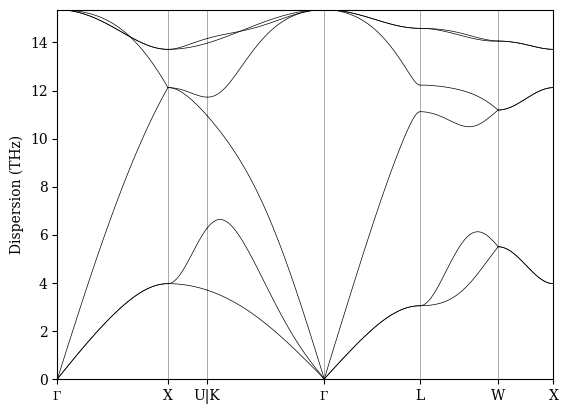

In [17]:
node.outputs.phonon_bands.show_mpl()